# Minimax Linkage 

There is no minimax linkage implemented in ```scipy.cluster.hierarchy``` as of Feb 2021. There is a standalone package [pyprotoclust](https://github.com/andgoldschmidt/pyprotoclust), possibly the only python package available for minimax linkage, but a simple pip install doesn't always work. 

Below is a brute force implementation. 

There is a nearest neighbor chain algorithm which is used in scipy for complete linkage. Minimax linkage can be implemented in the same way. 

The update rule of minimax linkage is

\begin{align*}
d(G_1 \cup G_2, H) = \min_{i\in G_1\cup G_2 \cup H} \max_{j\in G_1\cup G_2 \cup H} d_{ij}.
\end{align*}

## Brute Force

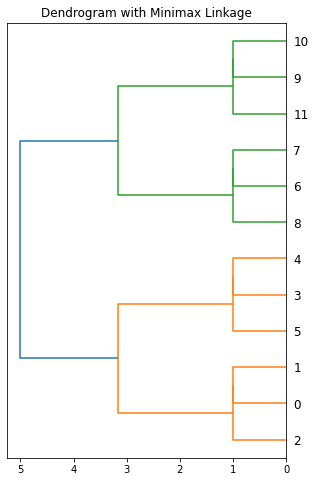

CPU times: user 792 ms, sys: 194 ms, total: 986 ms
Wall time: 999 ms


,x,y,dist,num_pts,prototype
0,0,1,1.000000,2,0
1,2,12,1.000000,3,0
2,3,4,1.000000,2,3
3,5,14,1.000000,3,3
4,6,7,1.000000,2,6
5,8,16,1.000000,3,6
6,9,10,1.000000,2,9
7,11,18,1.000000,3,9
8,13,15,3.162278,6,1
9,17,19,3.162278,6,8


In [1]:
%%time

import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

def minimax_linkage(dist):
    n = int((np.sqrt(8*len(dist) + 1) + 1)/2)
    
    def d(i, j): return dist[n*i+j-((i+2)*(i+1))//2] if i<j else (0 if i==j else d(j, i))
    def r(i, G): return max(d(i, j) for j in G)
    
    Z = []
    clusters = {i: set([i]) for i in range(n)}
    for i in range(n-1):
        min_d = math.inf
        for (idxG, G), (idxH, H) in combinations(clusters.items(), 2):
            x, dminimax = min(((x, r(x, G|H)) for x in G|H), key=lambda pt_max_d: pt_max_d[1])
            if dminimax < min_d:
                min_d = dminimax
                to_merge = [idxG, idxH, dminimax, len(G|H), x]
        Z.append(to_merge)
        idxG, idxH, _, _, _ = to_merge
        clusters[n+i] = clusters.pop(idxG) | clusters.pop(idxH)
        
    return np.array(Z)

X = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
Z = minimax_linkage(pdist(X))
# Z = hierarchy.complete(pdist(X))

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
hierarchy.dendrogram(Z[:, :4], ax=ax, orientation='left')
ax.set(title='Dendrogram with Minimax Linkage')
plt.show()

DataFrame(Z, columns=['x', 'y', 'dist', 'num_pts', 'prototype']).astype({'x': int, 'y': int, 'num_pts': int, 'prototype': int})

## [Nearest-Neighbor Chain Algorithm](https://en.wikipedia.org/wiki/Nearest-neighbor_chain_algorithm)

Part of the code from SciPy. 

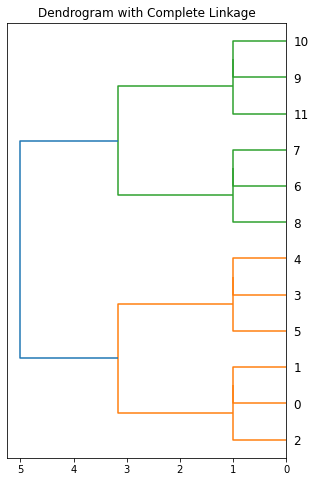

,x,y,dist,num_pts,prototype
0,0,1,1.000000,2,0
1,2,12,1.000000,3,0
2,3,4,1.000000,2,3
3,6,7,1.000000,2,6
4,5,14,1.000000,3,3
5,8,15,1.000000,3,6
6,9,10,1.000000,2,9
7,11,18,1.000000,3,9
8,13,16,3.162278,6,1
9,17,19,3.162278,6,8


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist


class LinkageUnionFind:
    """Structure for fast cluster labeling in unsorted dendrogram."""
#     cdef int[:] parent
#     cdef int[:] size
#     cdef int next_label

    def __init__(self, n):
        self.parent = np.arange(2 * n - 1)
        self.next_label = n
        self.size = np.ones(2 * n - 1)

    def merge(self, x, y):
        self.parent[x] = self.next_label
        self.parent[y] = self.next_label
        size = self.size[x] + self.size[y]
        self.size[self.next_label] = size
        self.next_label += 1
        return size

    def find(self, x):
        p = x

        while self.parent[x] != x:
            x = self.parent[x]

        while self.parent[p] != x:
            p, self.parent[p] = self.parent[p], x

        return x


def label(Z, n):
    """Correctly label clusters in unsorted dendrogram."""
    uf = LinkageUnionFind(n)
    for i in range(n - 1):
        x, y = int(Z[i, 0]), int(Z[i, 1])
        x_root, y_root = uf.find(x), uf.find(y)
        if x_root < y_root:
            Z[i, 0], Z[i, 1] = x_root, y_root
        else:
            Z[i, 0], Z[i, 1] = y_root, x_root
        Z[i, 3] = uf.merge(x_root, y_root)
        


def condensed_index(n, i, j):
    """
    Calculate the condensed index of element (i, j) in an n x n condensed
    matrix.
    """
    if i < j:
        return int(round(n * i - (i * (i + 1) / 2) + (j - i - 1)))
    elif i > j:
        return int(round(n * j - (j * (j + 1) / 2) + (i - j - 1)))

    
# def nn_chain(dists, n, method):
def minimax(dists):
    """Perform hierarchy clustering using nearest-neighbor chain algorithm.
    Parameters
    ----------
    dists : ndarray
        A condensed matrix stores the pairwise distances of the observations.
    Returns
    -------
    Z : ndarray, shape (n - 1, 4)
        Computed linkage matrix.
    """
    n = int((np.sqrt(8*len(dists) + 1) + 1)/2)
    
    Z_arr = np.empty((n - 1, 5))
    Z = Z_arr

    D = dists.copy()  # Distances between clusters.
    size = np.ones(n, dtype=np.intc)  # Sizes of clusters.
    
    indices = [set([i]) for i in range(n)]

#     new_dist = linkage_methods[method]

    # Variables to store neighbors chain.
    cluster_chain = np.ndarray(n, dtype=np.intc)
    chain_length = 0

#     cdef int i, j, k, x, y, nx, ny, ni
#     cdef double dist, current_min

    for k in range(n - 1):
        if chain_length == 0:
            chain_length = 1
            for i in range(n):
                if size[i] > 0:
                    cluster_chain[0] = i
                    break

        # Go through chain of neighbors until two mutual neighbors are found.
        while True:
            x = cluster_chain[chain_length - 1]

            # We want to prefer the previous element in the chain as the
            # minimum, to avoid potentially going in cycles.
            if chain_length > 1:
                y = cluster_chain[chain_length - 2]
                current_min = D[condensed_index(n, x, y)]
            else:
                current_min = np.inf   # NPY_INFINITYF

            for i in range(n):
                if size[i] == 0 or x == i:
                    continue
                
                dist = D[condensed_index(n, x, i)]
                if dist < current_min:
                    current_min = dist
                    y = i

            if chain_length > 1 and y == cluster_chain[chain_length - 2]:
                break

            cluster_chain[chain_length] = y
            chain_length += 1

        # Merge clusters x and y and pop them from stack.
        chain_length -= 2

        # This is a convention used in fastcluster.
        if x > y:
            x, y = y, x

        # get the original numbers of points in clusters x and y
        nx = size[x]
        ny = size[y]

        # merge x and y. Cluster x will be dropped, and y will be replaced with the new cluster
        indices[y] |= indices[x]
        indices[x] = set()
        
        prototype, minmax = min(((j, max(dists[condensed_index(n, j, k)] if j!=k else 0 for k in indices[y])) for j in indices[y]), key=lambda pt_max: pt_max[1])
        
        # Record the new node.
        Z[k, 0] = x
        Z[k, 1] = y
        Z[k, 2] = current_min
        Z[k, 3] = nx + ny
        Z[k, 4] = prototype
        size[x] = 0  # Cluster x will be dropped.
        size[y] = nx + ny  # Cluster y will be replaced with the new cluster

        # Update the distance matrix.
        for i in range(n):
            ni = size[i]
            if ni == 0 or i == y:
                continue
                
            # D[condensed_index(n, i, y)] = max(D[condensed_index(n, i, x)], D[condensed_index(n, i, y)])  # complete linkage
            
            all_indices = indices[y] | indices[i]
            D[condensed_index(n, i, y)] = min(max(dists[condensed_index(n, j, k)] if j!=k else 0 for k in all_indices) for j in all_indices)  # minimax linkage, 實測先抄到 np.array 再取 minmax 反而更慢
            
            # 要 implement minimax 需要知道 x y 裡各有哪些原本資料點的 index，
            # 原本的 distance matrix 要從 dists 裡拿，因為 D 裡的值會一直被覆蓋過去

    # Sort Z by cluster distances.
    order = np.argsort(Z_arr[:, 2], kind='mergesort')
    Z_arr = Z_arr[order]

    # Find correct cluster labels inplace.
    label(Z_arr, n)

    return Z_arr


X = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
Z = minimax(pdist(X))

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
hierarchy.dendrogram(Z[:, :4], ax=ax, orientation='left')
ax.set(title='Dendrogram with Complete Linkage')
plt.show()

DataFrame(Z, columns=['x', 'y', 'dist', 'num_pts', 'prototype']).astype({'x': int, 'y': int, 'num_pts': int, 'prototype': int})

## Performance

用舊的 code 跑出來的（不計算 prototype）

In [11]:
%%timeit

# using np.max and np.min

import numpy as np

n = 100
np.random.seed(0)
X = np.random.rand(n, 2)
Z = minimax(pdist(X))

874 ms ± 92.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

# using python built-in

import numpy as np

n = 100

np.random.seed(0)
X = np.random.rand(n, 2)
Z = minimax(pdist(X))

504 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


CPU times: user 2min 32s, sys: 127 ms, total: 2min 32s
Wall time: 2min 33s


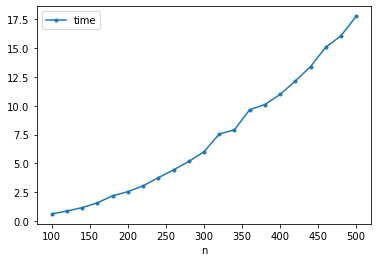

In [2]:
%%time

import time
import numpy as np
from pandas import DataFrame

np.random.seed(0)
n_pts = np.arange(100, 501, 20)
elapsed_time = []

def test_run(n):
    X = np.random.rand(n, 2)
    Z = minimax(pdist(X))    

for n in n_pts:
    t = time.process_time()
    test_run(n)
    elapsed_time.append(time.process_time() - t)
    
df = DataFrame({'n': n_pts, 'time': elapsed_time}).set_index('n')
df.plot(style='.-')
pass

In [3]:
df

,time
n,
100,0.618942
120,0.868634
140,1.165988
160,1.584192
180,2.195476
200,2.550525
220,3.055468
240,3.760503
260,4.438697


In [5]:
from pandas import DataFrame

n = len(X)

DataFrame([[condensed_index(12, i, j) if i>j else '' for j in range(12)] for i in range(12)])

,0,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,,
1,0,,,,,,,,,,,
2,1,11,,,,,,,,,,
3,2,12,21,,,,,,,,,
4,3,13,22,30,,,,,,,,
5,4,14,23,31,38,,,,,,,
6,5,15,24,32,39,45,,,,,,
7,6,16,25,33,40,46,51,,,,,
8,7,17,26,34,41,47,52,56,,,,
9,8,18,27,35,42,48,53,57,60,,,


## Demonstration 

顏色會亂跳

In [11]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import complete, single, dendrogram, fcluster, median
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from ipywidgets import interact

data = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
dist = pdist(data)

Z = complete(dist)
df = DataFrame(data, columns=['x', 'y'])

@interact(cut=(0, 5, 0.2))
def f(cut=1.8):
    df['hue'] = [cm.tab20(idx) for idx in fcluster(Z, t=cut, criterion='distance')]
    fx, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    dendrogram(Z, ax=ax1, link_color_func=lambda _: 'black')
    ax1.axhline(y=cut, c='r')

    sns.scatterplot(x='x', y='y', data=df, ax=ax2, hue='hue', legend=None, s=200)
    ax2.set(aspect=1, xlim=(-1, 5), ylim=(-1, 5))
    for i, (x, y) in enumerate(data):
        ax2.text(x+0.2, y+0.2, i)

    plt.show()

interactive(children=(FloatSlider(value=1.8, description='cut', max=5.0, step=0.2), Output()), _dom_classes=('…

In [26]:
pip install pyminimax

Note: you may need to restart the kernel to use updated packages.


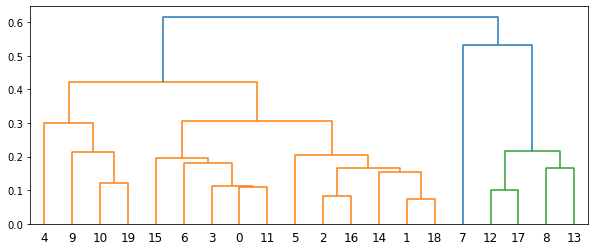

interactive(children=(FloatSlider(value=0.35, description='cut', max=0.7164147705585854, step=0.05), Output())…

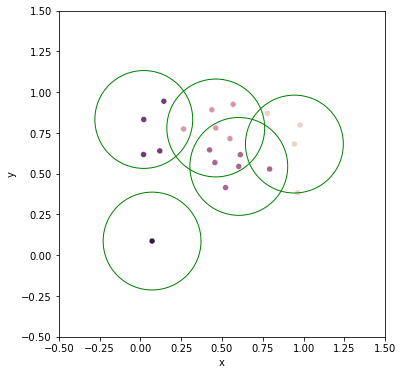

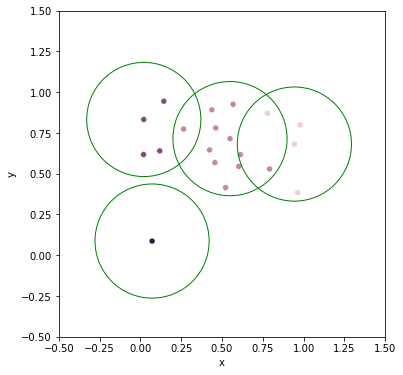

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from pyminimax import minimax, fcluster_prototype
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram
from ipywidgets import interact
from matplotlib import cm

np.random.seed(0)
X = np.random.rand(20, 2)

Z = minimax(pdist(X), return_prototype=True)

plt.figure(figsize=(10, 4))
dendrogram(Z[:, :4])
plt.show()

max_dist = max(Z[:, 2])

@interact(cut=(0, max_dist+0.1, 0.05))
def f(cut=0.35):
    clust_proto = fcluster_prototype(Z, t=cut, criterion='distance')
    protos = np.unique(clust_proto, axis=0).T[1]

    fig = plt.figure(figsize=(6, 6))
    df = DataFrame(np.concatenate([X, clust_proto], axis=1), columns=['x', 'y', 'clust', 'proto'])
    df['hue'] = df['clust'].map(int).map(cm.tab20)
#     ax = sns.scatterplot(data=df, x='x', y='y', hue='hue', legend=None)
    ax = sns.scatterplot(data=df, x='x', y='y', hue='clust', legend=None)
    ax.set(xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), aspect=1)
    
    for proto in protos:
        circle = plt.Circle(X[proto], cut, edgecolor='g', facecolor='none', clip_on=False)
        ax.add_patch(circle)
    plt.show()

f(cut=0.3)
f(cut=0.35)

In [12]:
DataFrame(Z)

,0,1,2,3,4
0,1.0,18.0,0.072653,2.0,1.0
1,2.0,16.0,0.084000,2.0,16.0
2,12.0,17.0,0.101950,2.0,17.0
3,0.0,11.0,0.109071,2.0,0.0
4,3.0,23.0,0.113781,3.0,11.0
5,10.0,19.0,0.122410,2.0,10.0
6,14.0,20.0,0.153313,3.0,1.0
7,8.0,13.0,0.166485,2.0,8.0
8,21.0,26.0,0.167219,5.0,16.0
9,6.0,24.0,0.180002,4.0,11.0


In [16]:
DataFrame(X)

,0,1
0,0.548814,0.715189
1,0.602763,0.544883
2,0.423655,0.645894
3,0.437587,0.891773
4,0.963663,0.383442
5,0.791725,0.528895
6,0.568045,0.925597
7,0.071036,0.087129
8,0.020218,0.832620
9,0.778157,0.870012


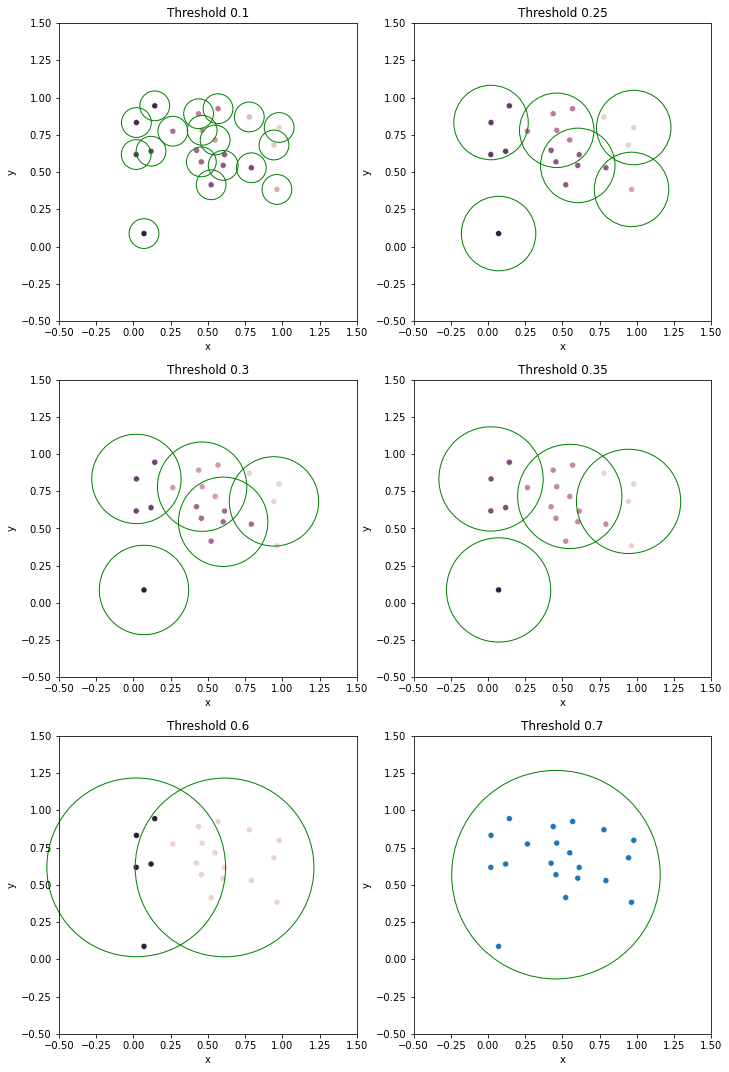

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from pyminimax import minimax, fcluster_prototype
from scipy.spatial.distance import pdist

np.random.seed(0)
X = np.random.rand(20, 2)
Z = minimax(pdist(X), return_prototype=True)

cuts = [0.1, 0.25, 0.3, 0.35, 0.6, 0.7]

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for ax, cut in zip(axs.ravel(), cuts):
    clust_proto = fcluster_prototype(Z, t=cut, criterion='distance')    
    
    df = DataFrame(np.concatenate([X, clust_proto], axis=1), columns=['x', 'y', 'clust', 'proto'])    
    sns.scatterplot(data=df, x='x', y='y', hue='clust', legend=None, ax=ax)
    
    ax.set(xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), aspect=1, title=f'Threshold {cut}')
    protos = np.unique(df['proto'].map(int).values)
    for proto in protos:
        circle = plt.Circle(X[proto], cut, edgecolor='g', facecolor='none', clip_on=False)
        ax.add_patch(circle)
        
fig.tight_layout()
plt.show()

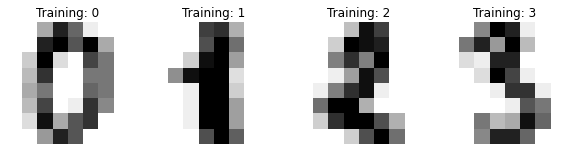

In [1]:
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split


digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)



In [4]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
from pyminimax import minimax, fcluster_prototype
from scipy.spatial.distance import pdist

df = datasets.load_digits(as_frame=True)['frame']

df147 = df[(df['target']==1) | (df['target']==4) | (df['target']==7)]
X = df147.iloc[:, :-1].values

Z = minimax(pdist(X), return_prototype=True)
# clust_proto = fcluster_prototype(Z, t=cut, criterion='distance')

plt.figure(figsize=(10, 4))
dendrogram(Z[:, :4])
plt.show()
